In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

# Download the data

In [2]:
mnist_dev = torchvision.datasets.MNIST('./data', train=True, download = True)
mnist_test = torchvision.datasets.MNIST('./data', train=False, download=True)

In [3]:
print(mnist_dev)
type(mnist_dev)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train


torchvision.datasets.mnist.MNIST

In [4]:
x_dev = mnist_dev.data/255.0
print(x_dev.shape)
y_dev = mnist_dev.targets
print(y_dev.shape)
mnist_dev.classes


torch.Size([60000, 28, 28])
torch.Size([60000])


['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

lable tensor(5)


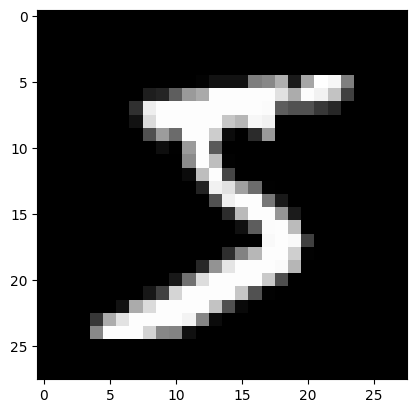

lable tensor(0)


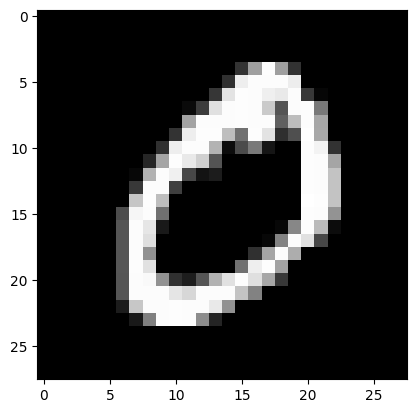

lable tensor(4)


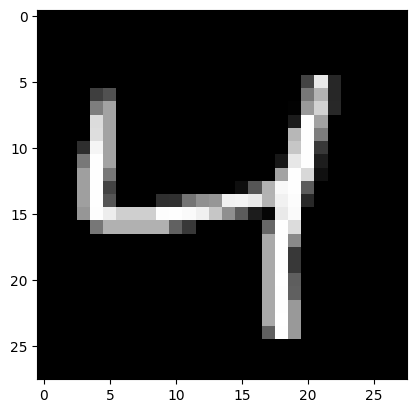

lable tensor(1)


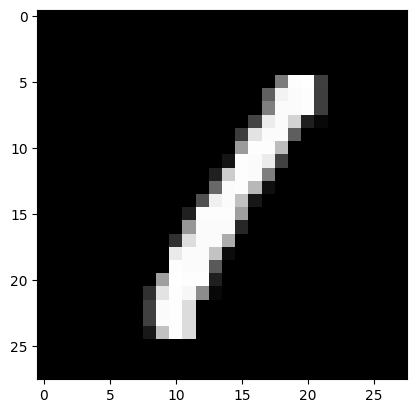

lable tensor(9)


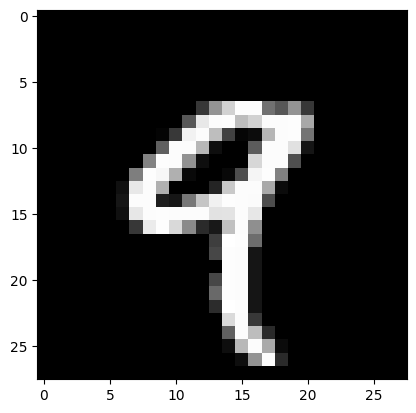

In [5]:
for i in range(5):
    print("lable", y_dev[i])
    plt.imshow(x_dev[i], cmap='gray')
    plt.show()

Note that setting 'train=True' gives you the development set
We need to split dev_data into the training and validation

In [6]:
ntrain = 50_000
print(x_dev.shape)
x_train, y_train = x_dev[:ntrain].flatten(1), y_dev[:ntrain]
print(x_train.shape)
x_val, y_val = x_dev[ntrain:].flatten(1), y_dev[ntrain:]

torch.Size([60000, 28, 28])
torch.Size([50000, 784])


## Xavier initialization
### !!!Do not forget reguries_grad_()
- Variance of the weight should be 1/n to preserve input's variance after applying affine operations
- Var(Score) = N*Var(weight)*Var(inputs)
- If weight is initialized by Uniform distribution, we could do by
    - Uniform(-np.sqrt(6/fan_in + fan_out), np.sqrt(6/fan_in + fan_out))
- If weight is initialized by Normal distribution, we could do by
    - Normal(0, 1/n)
    - Normal(0, 2/n) if the activation function is ReLU
    - Standard deviation = np.sqrt(2/fan_in+fan_out)
    - When we use torch.randn(normal distribution),
        - weight = torch.randn(fan_in, fan_out)*np.sqrt(2/fan_in+fan_out)

In [7]:
num_features = 28*28
num_classes = 10

weight = torch.randn(num_features, num_classes) * np.sqrt(2/num_features+num_classes)
weight.requires_grad_()
bias = torch.zeros(num_classes, requires_grad=True)
print(weight)
print(bias)

tensor([[-1.2566, -3.1365, -0.1870,  ...,  0.7040,  0.9958, -2.7340],
        [ 1.1343,  4.3857,  1.6055,  ..., -1.2900,  0.1832,  0.8818],
        [-0.9191,  1.6287, -0.4346,  ...,  1.6202, -3.4267,  7.2912],
        ...,
        [ 0.1686, -1.0516,  4.8744,  ..., -1.5316,  1.3028, -0.9969],
        [ 0.9757, -0.7693, -2.4755,  ...,  1.2036,  0.2823, -2.6140],
        [-2.6084, -1.8496, -3.9950,  ..., -2.4091, -0.5021, -0.2228]],
       requires_grad=True)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


In [8]:
print(weight.shape)
w = torch.randn([1, 1, 10, 10])
print(w.squeeze().shape) ## shrink one dimentions which has one
print(w.unsqueeze(0).shape) # expand dimentions

torch.Size([784, 10])
torch.Size([10, 10])
torch.Size([1, 1, 1, 10, 10])


In [9]:
def model(input):
    return log_softmax(input @ weight + bias)
def log_softmax(input):
    return input - input.exp().sum(-1).log().unsqueeze(-1)
def nll_loss(output,target):
    return -output[range(target.shape[0]), target].mean()
loss_fn = nll_loss

def get_accuracy(output, target):
    pred = torch.argmax(output, dim=1)
    return (pred == target).float().mean()


In [10]:
batch_size = 64
input = x_train[:batch_size]
target = y_train[:batch_size]
pred = model(x_train[:batch_size])
loss = loss_fn(pred, target)
accuracy = get_accuracy(pred, target)

In [11]:
pred_sample = torch.argmax(pred[0], dim=-1)
sample_target = target[0]
print(pred_sample)
print(sample_target)
print(accuracy)
print(loss)

tensor(0)
tensor(5)
tensor(0.1094)
tensor(42.4930, grad_fn=<NegBackward0>)


## Torch.nn.functional

In [12]:
import torch.nn.functional as F

In [13]:
# torch.nn.functional.cross_entropy combins log_softmax and negative log likelihood

def model(xb):
    return xb @ weight + bias

loss_fc = F.cross_entropy
pred = model(input)
loss = loss_fc(pred, target)
print(loss)

tensor(42.4930, grad_fn=<NllLossBackward0>)


In [14]:
print(nll_loss(log_softmax(pred), target))

tensor(42.4930, grad_fn=<NegBackward0>)


 ## nn.Module

In [15]:
from torch import nn

class LogisticRegression(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(num_features, num_classes) * np.sqrt(2/(num_features + num_classes)))
        self.bias = nn.Parameter(torch.zeros(num_classes))

    def forward(self, input):
        return input @ self.weight + self.bias


In [16]:
model = LogisticRegression(num_features=28*28, num_classes=10)
pred = model.forward(x_train[:ntrain])
print(nll_loss(log_softmax(pred), y_train[:ntrain]))

tensor(2.3731, grad_fn=<NegBackward0>)


## Training Loop

In [17]:
# ntrain = #train data samples
# batch_size = batch size
# loss_fc = F.cross_entropy
def train(model, num_epochs, learning_rate):
    for epoch in range(num_epochs):
        for i in range(int(np.ceil(ntrain/batch_size))): ## number of samples in minibatch
            # Get mini_batch
            start_i = i*batch_size
            end_i = min(start_i + batch_size, ntrain)
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]

            # Get prediction
            pred = model(xb)

            # Get loss
            loss = loss_fc(pred, yb)
            
            # get gradient
            model.zero_grad() # reset gradient of loss function wrt parameters
            loss.backward() # compute gradients by backpropagation

            # Optimization
            with torch.no_grad():
                for param in model.parameters():
                    param -= learning_rate * param.grad
            

In [18]:
model = LogisticRegression(num_features=28*28, num_classes=10)
train(model, num_epochs=10, learning_rate=0.01)
pred = log_softmax(model(x_val))
accuracy = get_accuracy(pred, y_val)
print(accuracy)

tensor(0.9079)


In [19]:
test = x_val[0].reshape(28,28)
print(test.shape)

torch.Size([28, 28])


[array(3), array(8), array(6), array(9), array(6), array(9), array(5), array(5), array(8), array(4)]


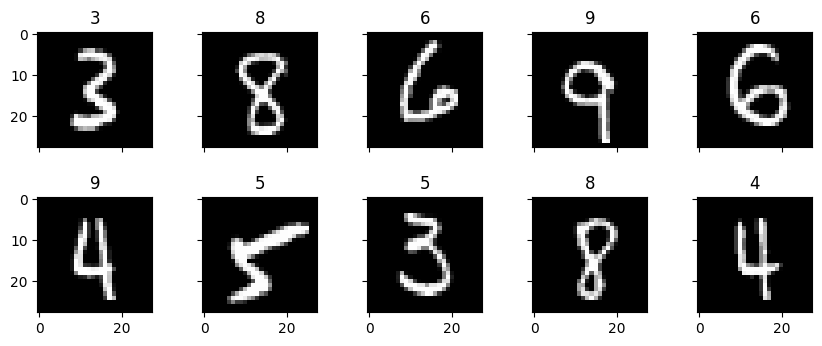

In [20]:
from mpl_toolkits.axes_grid1 import ImageGrid

num_images = 10
image = []
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.5)
preds = []

for i in range(num_images):
    pred1 = torch.argmax(pred[i], dim=-1).numpy()
    gt = y_val[i]
    image.append(x_val[i].reshape(28,28))
    preds.append(pred1)

counter = 0
print(preds)

for ax, im in zip(grid, image):
    ax.set_title(str(preds[counter]))
    ax.imshow(im, cmap="gray")
    counter = counter + 1
plt.show()


## nn.Linear

In [21]:
class LogisticRegression(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.lin = nn.Linear(num_features, num_classes)

    def forward(self, input):
        return self.lin(input)

In [22]:
def initialize_weight(module):
    if isinstance(module, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_normal_(module.weight)
        module.bias.data.zero_()

In [23]:
model = LogisticRegression(num_features=28*28, num_classes=10)
model.apply(initialize_weight)

train(model, num_epochs=10, learning_rate=0.01)

loss_func_val = F.cross_entropy

train_target = y_train[:batch_size]
pred_train =model(x_train[:batch_size])
loss_train = loss_func_val(pred_train, train_target)
acc_train = get_accuracy(pred_train, train_target)

val_target = y_train[:batch_size]
pred_val = model(x_val[:batch_size])
loss_val = loss_func_val(pred_val, val_target)
acc_val = get_accuracy(pred_val, val_target)

print("train_acc", acc_train)
print("train_loss", loss_train)

print("val_acc", acc_val)
print("val_loss", loss_val)

train_acc tensor(0.9375)
train_loss tensor(0.3194, grad_fn=<NllLossBackward0>)
val_acc tensor(0.0938)
val_loss tensor(6.0585, grad_fn=<NllLossBackward0>)


## torch.optim

In [24]:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

In [25]:
def train(model, optimizer, num_epochs):
    for epoch in range(num_epochs):
        for i in range(int(np.ceil(len(x_train)/batch_size))):
            start_i = i * batch_size
            end_i = min(start_i+batch_size, len(x_train))
            xb=x_train[start_i:end_i]
            yb=y_train[start_i:end_i]

            #prediction
            pred = model(xb)

            #evaluate loss
            loss = F.cross_entropy(pred, yb)

            #obtain gradients
            optimizer.zero_grad()
            loss.backward()

            #update params
            optimizer.step()

            


In [26]:
model = LogisticRegression(num_features=28*28, num_classes=10)
model.apply(initialize_weight)

train(model, optimizer, num_epochs=2)

In [27]:
def validation(model, dataset, data_name=""):
    if isinstance(dataset, torch.utils.data.TensorDataset):
        xb, targets = dataset[:]
        pred = model(xb)
    else:
        print("should be Tensordataset")
    loss = F.cross_entropy(pred, targets)
    acc = get_accuracy(pred, targets)
    print(data_name)
    print("loss:" , loss)
    print("accuracy", acc)
    print()

In [28]:
from torch.utils.data import TensorDataset
train_set = TensorDataset(x_train, y_train)
val_set = TensorDataset(x_val, y_val)

In [29]:
validation(model, train_set, data_name="train")
validation(model, val_set, data_name="valdation")

train
loss: tensor(2.3896, grad_fn=<NllLossBackward0>)
accuracy tensor(0.0773)

valdation
loss: tensor(2.3810, grad_fn=<NllLossBackward0>)
accuracy tensor(0.0845)



## Dataset

In [30]:
from torch.utils.data import TensorDataset

train_set = TensorDataset(x_train, y_train)

In [31]:
print(len(train_set))

50000


In [32]:
def initialize_weight1(module):
    if isinstance(module, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_normal_(module.weight)
        module.bias.data.zero_()

In [33]:
ntrain

50000

In [34]:
def train(model, optimizer, train_set, num_epochs):
    for epoch in range(num_epochs):
        for i in range(int(len(train_set)/batch_size)):
            #get minibatch
            start_i = i * batch_size
            end_i = min(start_i+batch_size, len(train_set))
            xb, yb = train_set[start_i:end_i]
            # print(xb.shape)
            #prediction
            pred = model(xb)

            #loss
            loss = F.cross_entropy(pred, yb)

            #obtain derivatives
            optimizer.zero_grad()
            loss.backward()

            #update parameters
            optimizer.step()

In [35]:
model = LogisticRegression(num_features=28*28, num_classes=10)
model.apply(initialize_weight1)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train(model, optimizer, train_set, num_epochs=2)

In [36]:
train_set = TensorDataset(x_train[:1000], y_train[:1000])
val_set = TensorDataset(x_val[:1000], y_val[:1000])

validation(model, train_set, data_name="train")
validation(model, val_set, data_name="validation")

train
loss: tensor(0.5472, grad_fn=<NllLossBackward0>)
accuracy tensor(0.8540)

validation
loss: tensor(0.5637, grad_fn=<NllLossBackward0>)
accuracy tensor(0.8660)



## DataLoader
- You can create a DataLoader for any Dataset

In [37]:
from torch.utils.data import DataLoader
train_loader=DataLoader(train_set, batch_size=16, shuffle=True)
val_loader=DataLoader(val_set, batch_size=16, shuffle=True)

In [38]:
len(train_loader)
for xb, yb in train_loader:
    # print(len(xb))
    pass

In [39]:
def train(model, optimizer, train_dataloader, num_epochs):
    for epoch in range(num_epochs):
        for input, target in train_dataloader:
            #Generate prediction
            pred = model(input)

            #loss
            loss = F.cross_entropy(pred, target)

            #calculate gradients
            optimizer.zero_grad()
            loss.backward()

            #update paramteres
            optimizer.step()
            

In [40]:
model = LogisticRegression(num_features=28*28, num_classes=10)
model.apply(initialize_weight1)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train(model, optimizer, train_loader, num_epochs=2)

In [41]:
train_set = TensorDataset(x_train, y_train)
validation_set = TensorDataset(x_val, y_val)
validation(model, train_set, data_name="train")
validation(model, validation_set, data_name="validation")

train
loss: tensor(1.4960, grad_fn=<NllLossBackward0>)
accuracy tensor(0.6622)

validation
loss: tensor(1.4628, grad_fn=<NllLossBackward0>)
accuracy tensor(0.6914)



## Validation
- Since we do not need backpropagation for the validation set, we can use 2x large batches. NO NEED TO BE SHUFFLE For vallidation data. 
- We should shuffle training data to avoid correlation between batches

In [42]:
train_set = TensorDataset(x_train, y_train)
validation_set = TensorDataset(x_val, y_val)

dataloaders={}
dataloaders['train']=DataLoader(train_set, batch_size=16, shuffle=True)
dataloaders['val']=DataLoader(validation_set, batch_size=16, shuffle=False)

## model.train() and model.eval()
- since batch_normalization or dropout layers are behaving different way in train and evalation

In [43]:
def train(model, optimizer, dataloaders, num_epochs):
    for epoch in range(num_epochs):
        # Train
        model.train()
        for input, target in dataloaders['train']:
            #prediction
            pred = model(input)
            #loss
            loss = F.cross_entropy(pred, target)
            #gradient
            optimizer.zero_grad()
            loss.backward()
            #update
            optimizer.step()

        # Evaluation
        model.eval()
        loss = 0
        n_correct = 0
        n_samples = 0
        for input, target in dataloaders['val']:
            #prediction
            pred = model(input)
            #loss
            # print(pred.shape)
            loss += F.cross_entropy(pred, target).sum()
            n_correct += (pred.argmax(-1)==target).sum()
            n_samples += len(target)
        avg_loss = loss / len(dataloaders['val'])
        accuracy = n_correct / n_samples

        print(f"Epoch {epoch}: loss={avg_loss:.3f} accuracy={accuracy:.3f}")


In [44]:
model = LogisticRegression(num_features=28*28, num_classes=10)
model.apply(initialize_weight1)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train(model, optimizer, dataloaders, num_epochs=2)

Epoch 0: loss=0.405 accuracy=0.893
Epoch 1: loss=0.350 accuracy=0.904


## CNN
- convolution neural network

In [45]:
#output size
def output_size(input_size, kernel_size, stride, padding, layers=0):
    out=input_size
    for i in range(layers):
        out= np.floor((out+(2*padding) - kernel_size)/stride) + 1
    return int(out)

In [46]:
output_size(28, 3, 2, 1, 3)

4

In [47]:
class CNN(nn.Module):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.conv1=nn.Conv2d(1, num_channels, kernel_size=3, stride=2, padding=1)
        self.conv2=nn.Conv2d(num_channels, num_channels, kernel_size=3,stride=2, padding=1)
        self.conv3=nn.Conv2d(num_channels, num_classes, kernel_size=3, stride=2, padding=1)
        # self.dense=nn.Linear(num)

    def forward(self, input):
        x = input.view(-1, 1, 28, 28)
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.avg_pool2d(x, 4)
        x = x.squeeze()
        return x


In [48]:
test = x_train[1:4]
print(test.shape)
print(test.view(-1, 1, 28, 28).shape)

torch.Size([3, 784])
torch.Size([3, 1, 28, 28])


In [49]:
cnn = CNN(num_channels=16, num_classes=10)
counter = 0

size_train = int(np.floor(x_dev.shape[0] * 0.8))
size_val = int(np.floor(x_dev.shape[0] * 0.1))
size_test = int(np.floor(x_dev.shape[0] * 0.1))

x_train, y_train = x_dev[:size_train], y_dev[:size_train]
x_val, y_val = x_dev[size_train:size_train+size_val], y_dev[size_train:size_train+size_val]
start_idx = size_train+size_val
x_test, y_test = x_dev[start_idx:start_idx+size_test], y_dev[start_idx:start_idx+size_test]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(x_train.shape[0] + x_val.shape[0] + x_test.shape[0])

train_set = TensorDataset(x_train, y_train)
val_set = TensorDataset(x_val, y_val)
test_set = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

Dataloaders = {}
Dataloaders['train']=train_loader
Dataloaders['val']=val_loader
Dataloaders['test']=test_loader

torch.Size([48000, 28, 28])
torch.Size([6000, 28, 28])
torch.Size([6000, 28, 28])
60000


In [50]:
for xb, yb in Dataloaders['train']:
    pred = cnn(xb)    
    break
print(pred.shape)
print(pred.squeeze().shape)
print(torch.argmax(pred.squeeze(), dim=-1))



torch.Size([16, 10])
torch.Size([16, 10])
tensor([2, 2, 2, 9, 2, 2, 2, 9, 2, 2, 2, 2, 9, 2, 2, 2])


In [51]:
model = CNN(num_channels=128, num_classes=10)
model.apply(initialize_weight1)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train(model, optimizer=optimizer, dataloaders=Dataloaders, num_epochs=2)

Epoch 0: loss=0.416 accuracy=0.878
Epoch 1: loss=0.301 accuracy=0.914


In [52]:
list(model.named_parameters())

[('conv1.weight',
  Parameter containing:
  tensor([[[[ 0.4323,  0.4717,  0.5230],
            [ 0.2518,  0.2785,  0.1837],
            [ 0.0323,  0.0908, -0.0051]]],
  
  
          [[[ 0.1008,  0.1894,  0.0224],
            [ 0.0923, -0.0236,  0.0531],
            [-0.0302, -0.1717, -0.0892]]],
  
  
          [[[ 0.1541,  0.0913, -0.1421],
            [ 0.1711,  0.0145, -0.1532],
            [ 0.1414, -0.0880, -0.1807]]],
  
  
          ...,
  
  
          [[[-0.0414,  0.0833,  0.0994],
            [ 0.0133,  0.1674,  0.1699],
            [ 0.0606,  0.1696,  0.1372]]],
  
  
          [[[ 0.0027, -0.0686, -0.0137],
            [-0.0672, -0.0498,  0.0868],
            [-0.0050, -0.0259, -0.0647]]],
  
  
          [[[ 0.0379,  0.0066,  0.0299],
            [-0.1263,  0.0481,  0.0138],
            [-0.0336, -0.0126,  0.0721]]]], requires_grad=True)),
 ('conv1.bias',
  Parameter containing:
  tensor([ 1.8046e-03,  7.8750e-02,  2.2229e-02,  1.5149e-01,  3.0425e-02,
          -9.7329e-

## nn.Seqential

In [53]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, input):
        return self.func(input)

In [54]:
test = x_train[1:10]


In [55]:
model = nn.Sequential(
    Lambda(lambda x: x.view(-1, 1, 28, 28)),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.squeeze()) #Lambda(lambda x; x.view(x.size(0), -1)))
)

## Tensor .size(0) and .shape[0] are equivalent

In [56]:
a = model(test)
b = model(test).view(model(test).size(0), -1)
print(b.shape)
print(a.shape)
print(a==b)

torch.Size([9, 10])
torch.Size([9, 10])
tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])


In [57]:
list(model.named_parameters())

[('1.weight',
  Parameter containing:
  tensor([[[[ 0.1592,  0.0659, -0.1020],
            [ 0.0352, -0.1845, -0.1714],
            [-0.0257,  0.0660,  0.0918]]],
  
  
          [[[ 0.2975,  0.0044, -0.0790],
            [-0.3127, -0.2805,  0.1095],
            [-0.2699,  0.1546, -0.0822]]],
  
  
          [[[-0.0865,  0.3150, -0.2044],
            [ 0.1343,  0.1307,  0.1068],
            [ 0.2841,  0.0026,  0.1943]]],
  
  
          [[[-0.0237, -0.0462, -0.2873],
            [-0.0724,  0.3278, -0.2370],
            [ 0.1401, -0.0484,  0.0493]]],
  
  
          [[[-0.2751, -0.0498, -0.1969],
            [-0.2250,  0.0203,  0.0522],
            [-0.1003, -0.1607, -0.3116]]],
  
  
          [[[ 0.2858, -0.2860, -0.2105],
            [ 0.2829, -0.2744, -0.0186],
            [-0.1719,  0.1927,  0.2614]]],
  
  
          [[[ 0.0301, -0.1227,  0.2517],
            [-0.1005,  0.0907, -0.1215],
            [-0.1843,  0.0841,  0.1997]]],
  
  
          [[[-0.2488,  0.2627, -0.0179],
    

In [58]:
model.apply(initialize_weight1)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)

train(model, optimizer=optimizer, dataloaders=Dataloaders, num_epochs=2)

Epoch 0: loss=0.432 accuracy=0.873
Epoch 1: loss=0.329 accuracy=0.897


## Use of GPUs for learning
- We should be careful if our all sets for deep learning are existing on GPU memory

In [59]:
print(torch.cuda.is_available())
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

True
cuda


In [60]:
# move our model to the device
model.to(device)

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): ReLU()
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): AdaptiveAvgPool2d(output_size=1)
  (8): Lambda()
)

In [61]:
Dataloaders = {}
Dataloaders['train'] = DataLoader(train_set, batch_size=16, shuffle=True)
Dataloaders['val'] = DataLoader(val_set, batch_size=16, shuffle=False)
Dataloaders['test'] = DataLoader(test_set, batch_size=16, shuffle=False)

In [62]:
def train(model, optimizer, dataloaders, num_epochs):
    for epoch in range(num_epochs):

        # training
        model.train()
        for input, target in dataloaders['train']:
            input, target = input.to(device), target.to(device)

            pred = model(input)
            loss = F.cross_entropy(pred, target)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
        
        # evaluation
        model.eval()
        loss = 0
        n_correct = 0
        n_samples = 0

        for input, target in dataloaders['val']:
            input, target = input.to(device), target.to(device)

            pred = model(input)
            loss += F.cross_entropy(pred, target)

            n_correct += (pred.argmax(-1) == target).sum()
            n_samples += len(dataloaders['val'])

        avg_loss = loss/len(dataloaders['val'])
        accuracy = n_correct/n_samples

        print(f"Epoch {epoch}: loss={avg_loss :.3f} accuracy={accuracy :.3f}")
    

In [63]:
model.apply(initialize_weight1)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

train(model, optimizer=optimizer, dataloaders=Dataloaders, num_epochs=2)

Epoch 0: loss=0.531 accuracy=0.036
Epoch 1: loss=0.438 accuracy=0.037


## Dropout
- runtime: Drop the input (set weight to zero) = Drop neurons randomly by drop out rate (p=self.p)
    - Scale the not dropped neurons output by $\frac{1}{1-p}$
        - To conserve input mean
- validation: Use all neurons

In [64]:
input = torch.randn(10, 10)
print("input_mean: ")
input_mean=input.mean()
print(input_mean.item())

mask = torch.zeros_like(input)
p = 0.2
mask.bernoulli_(p)
scale = 1 / (1-p)
droped_out = scale * mask * input
print()
print("dropped_out_mean:")
droped_out_mean=droped_out.mean()
print(droped_out_mean.item())

print()
#chenck the conservation of the mean
print("is_closed_enough?: ", np.isclose(input_mean.item(), droped_out_mean.item(), atol=1e-2))

input_mean: 
-0.0803307369351387

dropped_out_mean:
0.06150083616375923

is_closed_enough?:  False


In [65]:
class Dropout(nn.Module):
    # p:float, drop probability
    def __init__(self, p):
        super().__init__()
        self.p = p
    def forward(self, input):
        """
        Args:
            input:Pytorch tensor, arbitrary shape
        Returns:
            Pytorch tensor, same shape as input (Droped out)
        """
            
        if self.training:
            mask = torch.zeros_like(input)
            mask.bernoulli_(1-self.p) # set 1 to the not dropped input
            scaling = 1 / (1 - self.p)
            dropped_out = scaling * input * mask
        return dropped_out



In [66]:
#Test dropout
test = torch.randn(10_000)
dropout = Dropout(0.5)
test_droped_out = dropout(test)

# Obtain item in the tensor
print(test.mean().item())
print(type(test.mean().item()))

assert np.isclose(test.mean().item(), test_droped_out.mean().item(), atol=1e-2)

-0.0019391914829611778
<class 'float'>


## Batch normalization
- Batch normalization is a trick to obtain smooth loss landscape and improve training by preserving the variance of input as much as possible

- It is defined as the funciton
    $$y=\frac{x-\mu_x}{\sigma_x + \epsilon} \cdot \gamma + \beta$$
    - $\mu_x$: mean of input over the dimension c
    - $\sigma_x$: standard deviation(squareroot of variance) of input over the dimension c
    - $\epsilon$: numerical stability helper
    - $\gamma$: learnable paramter to undo the normalization (=>$\sigma_x$)
    - $\beta$: learnable paramter to undo the normalization (=>$\mu_x$)

In [67]:
# elemetn-wise multiplication
# Since the gamma and beta are having only num_features elements, 
# we need to add dimention to N and L
num_features = 10
dummy_gamma=torch.randn(num_features)
print(dummy_gamma)
augmented=dummy_gamma[None, :, None]
print(augmented[0, :, 0])

tensor([ 0.9952, -0.2993,  0.5384, -1.3421, -0.4111,  2.1712, -2.6291, -0.4553,
         0.8538, -1.7156])
tensor([ 0.9952, -0.2993,  0.5384, -1.3421, -0.4111,  2.1712, -2.6291, -0.4553,
         0.8538, -1.7156])


In [68]:
class BatchNorm(nn.Module):
    """ 
    Only uses batch statistics (no running mean for evaluation).
    Batch statistics are calculated for a single dimension (*input features)
    Gamma is initialized as 1, beta as 0

    Args: num_features: number of feature to calculate batch statistics for.
    """

    def __init__(self, num_features):
        super().__init__()
        """
        Model freely undo the normalization.
        Complete-undo brings
            Gamma -> standard deviation (=square root of the variance)
            Beta -> mean of input
        """
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, input):
        """
        Batch normalization over the dimension C of (N, C, L)

        Args:
            input: Pytorch tensor, shape[N, C, L]
            N: number of minibatch samples
            C: number of channels (input's dimension)
            L: shape of the one channel
                -RGB image: L=(H, W)
        Return:
            Pytorch tensor, same shape as input
        """

        eps = 1e-5 #helper for numerical stability

        aggregate_dims = [0, 2]
        mean = torch.mean(input, dim=aggregate_dims, keepdim=True)
        std = torch.std(input, dim=aggregate_dims, keepdim=True)

        input_normalized=(input-mean) / (std + eps)
        return self.gamma[None, :, None] * input_normalized + self.beta[None, :, None]


In [69]:
# test batch normalization

torch.random.manual_seed(42)
test = torch.randn(8, 2, 4)

b1 = BatchNorm(2)
test_b1 = b1(test)

# nn.BatchNorm1d
    # affine
    #   True >this module has leranable parameter
    # track_running_stats
    #   True >track running mean and standard deviation

b2 = nn.BatchNorm1d(2, affine=False, track_running_stats=False)
test_b2 = b2(test)

# torch.allclose 
    # checks if all input and other satisfy the condition
    # elementwise, for all elements of input and other
    # rtol > relattive tolerance
    # atol > absolute tolerance 
assert torch.allclose(test_b1, test_b2, rtol=2*1e-2)

## Resnet
- Resnet is the first network which is introduced residual connections
- Skip connection can solve problems such as vanishing and exploding gradients as the network gets deeper and deeper

In [70]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func=func
    def forward(self, x):
        return self.func(x)

if the stride is more than 1 or the in_channels is not equal to out_channels, we need to modify the shape of the input to add the second convolution output and before the final relu activation.

In this case, we should care the stride size and the subtraction between out_channel and in_channel

In [71]:
stride = 2
x = torch.randn(1, 1, 4, 4)
print(x.shape)
_x=x[:, :, ::stride, ::stride]
print(_x.shape)

torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 2, 2])


In [72]:
out_cha=32
in_cha=16
print("subtraction", out_cha-in_cha)
print("original channel", x.shape[1])

# F.pad configuration
# padding setting = (padding_left, right, top, bottom, front, back)

padded_inpput = F.pad(_x, (0, 0, 0, 0, 0, out_cha-in_cha), mode="constant", value=0) 
print(padded_inpput.shape)

subtraction 16
original channel 1
torch.Size([1, 17, 2, 2])


In [73]:
class ResidualBlock(nn.Module):
    """
    The residual block used by ResNet

    Args:
        in_channels: The number of channels (feature map) of the incoming embedding
        out_channels: The number of channels after the first convolution
        stride: Stride size of th first convolution, used for downsampling
    """

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        if stride > 1 or in_channels != out_channels:
            #Add strides in the skip connection and zeros for the new channels
            self.skip = Lambda(lambda x: F.pad(x[:, :, ::stride, ::stride],
             (0,0,0,0,0,out_channels - in_channels), mode="constant", value=0))
        else:
            self.skip = nn.Sequential()

        self.conv1=nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # bias term in the convolution layer will be erased by the batch-normalization
        self.conv2=nn.Conv2d(out_channels, out_channels, kernel_size=3, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        x1 = F.relu(self.bn1(self.conv1(input)))
        x2 = self.bn2(self.conv2(x1))
        return F.relu(x2 + self.skip(input))

In [74]:
class ResidualStack(nn.Module):
    """
    A stack of residual blocks

    Args:
        in_channels: The number of channels of the incomming embedding
        out_channels: The number of channels of the outgoing embedding
        stride: Stride size a the first convolution later for the downsampling
        num_blocks: Number of residual blocks
    """

    def __init__(self, in_channels, out_channels, stride, num_blocks):
        super().__init__()
        blocks = [ResidualBlock(in_channels, out_channels, stride=stride)]
        for _ in range(num_blocks-1):
            blocks.append(ResidualBlock(out_channels, out_channels))
        self.blocks = nn.ModuleList(blocks)

    def forward(self, input):
        x = input
        for block in self.blocks:
            x = block(x)
        return x

Model Structure
- a covolition latyer is always containing
    - Convolution layer
    - Batch Normalization
    - ReLU activation
- The each residual block has two comvolution layer with 1 skip connection
- We should __squeeze__ the final output to feed it to the fully-connected(dense) layer

Residual Architectures
- Args:
    - input: 32x32 images
    - Per-pixel mean subtracted
1. 3x3 Conv layer (input_cha=3, out cha=16)
    - Batch
    - ReLU activation
2. __SAME__ Residual stack (num_blocks = n, input_cha=16, out_channel=16)
    - Residual block (1st, stride=1)
        - 3x3 Same Convolution (Spacial reduction: 32->32)
        - Batch
        - ReLU
    - Residual block (2st-n)
        - 3x3 Same Convolution
        - Batch
        - ReLU
3. __VALID__ Residual stach (num_blocks=n, input_cha=16, out_cha=32)
    - Residual block (1st, strider=2)
        - 3x3 Valid Convolution (Spacial reduction: 32->16)
        - Batch
        - ReLU
    - Residual block (2st-n)
        - 3x3 Same Convolution
        - Batch
        - ReLU
4. __VALID__ Residual stach (num_blocks=n, input_cha=32, out_cha=64)
    - Residual block (1st, strider=2)
        - 3x3 Valid Convolution (Spacial reduction: 16->8)
        - Batch
        - ReLU
    - Residual block (2st-n)
        - 3x3 Same Convolution
        - Batch
        - ReLU
5. Average Pooling to reduce spacial dimension from 8x8 to 1x1 per channel
6. Lambda squeeze the output and flatten
7. Fully connected NN (input_dim=64, out_dim=num_class)

In [75]:
n=5
num_classes = 10

resnet = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(num_features=16),
    nn.ReLU(),
    ResidualStack(in_channels=16, out_channels=16, stride=1, num_blocks=n),
    ResidualStack(in_channels=16, out_channels=32, stride=2, num_blocks=n),
    ResidualStack(in_channels=32, out_channels=64, stride=2, num_blocks=n),
    nn.AdaptiveAvgPool2d(output_size=1),
    Lambda(lambda x: x.squeeze()),
    nn.Linear(in_features=64, out_features=num_classes)
)

## Access to the module(layer) weight and bias
- We need to initialize the weights of our model appropriately
- module.weight, module.bias

In [76]:
resnet.named_modules

<bound method Module.named_modules of Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): ResidualStack(
    (blocks): ModuleList(
      (0): ResidualBlock(
        (skip): Sequential()
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResidualBlock(
        (skip): Sequential()
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 1

In [77]:
def initialize_weight_Resnet(module): ##intilalize each layer(module)
    if isinstance(module, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.constant_(module.weight, 1) #initialize gamma with 1
        nn.init.constant_(module.bias, 0) #initialize beta with 0

resnet.apply(initialize_weight_Resnet)
print()

## Training of resnet
### Data loading

- Define data download class from the dataset server
- Define the transformation
    - mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]
    - Use precomputed mean and standard deviation of respective channel
- Down load the data using the transmormation

In [78]:
class CIFAR10Subset(torchvision.datasets.CIFAR10):
    """
    Ger a subset of the CIFAR10 dataset provided thougth torch.vision
    return the Dataset
    """

    def __init__(self, *args, idx=None, **kwargs):
        super().__init__(*args, **kwargs)

        if idx is None:
            return
        
        self.data=self.data[idx]
        target_np = np.array(self.targets)
        self.targets=target_np[idx].tolist()

## Transformation in precomputing
- We need to make the model be robust to wide variety of the transformation
- Usually a real-world image does not contain the full-body image of object
- Cropping is good data augmentation for the occulusion
- Horizonfilp is good data augmentation foe the robustness

In [79]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    normalize,
])

transform_eval = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [80]:
ntrain = 45_000
## creating dataset for dataloader
train_set = CIFAR10Subset(root='./data', train=True, idx=range(ntrain), download=True, transform=transform_train)
val_set = CIFAR10Subset(root='./data', train=True, idx = range(ntrain, 50_000), download=True, transform=transform_eval)
test_set = CIFAR10Subset(root='./data', train=False, download=True, transform=transform_eval)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [81]:
print("image size", train_set[0][0].shape)
print("target label", train_set[0][1])

image size torch.Size([3, 32, 32])
target label 6


In [82]:
from mpl_toolkits.axes_grid1 import ImageGrid
def PredandImage_visuallization(pred, x_val):
    transform_topilimage = transforms.ToPILImage()
    num_images = 10
    image = []
    fig = plt.figure(figsize=(30., 30.))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.5)
    preds = []
    
    for i in range(num_images):
        pred1 = torch.argmax(pred[i], dim=-1).numpy()
        gt = y_val[i]
        input_image = transform_topilimage(x_val[i])
        # print(x_val[i].shape)
        image.append(input_image)
        preds.append(pred1)

    counter = 0
    print(preds)

    for ax, im in zip(grid, image):
        ax.set_title(str(preds[counter]))
        ax.imshow(im)
        counter = counter + 1
    plt.show()  


In [83]:
from mpl_toolkits.axes_grid1 import ImageGrid

def Image_Grid_visuallization(dataset):
    transform_topilimage = transforms.ToPILImage()
    num_images = 10
    images = []
    fig = plt.figure(figsize=(10., 10.))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.5)
    targets = []

    for i in range(num_images):
        ima, target = transform_topilimage(dataset[i][0]), dataset[i][1]
        images.append(ima)
        targets.append(target)

    counter = 0

    for ax, im in zip(grid, images):
        ax.set_title(str(targets[counter]))
        ax.imshow(im)
        counter = counter + 1
    plt.show()  

In [84]:
print(train_set[0][0].shape)

torch.Size([3, 32, 32])


In [85]:
# creating data loader
# By enabling the pinned memory transfer, GPU pinns the certain memory partition and it can be accessed by the host device efficiently with low latency
dataloaders = {}
dataloaders['train']=torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
dataloaders['val']=torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
dataloaders['test']=torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

Next we push the model to our GPU 

In [86]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
resnet.to(device)

cuda


Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): ResidualStack(
    (blocks): ModuleList(
      (0): ResidualBlock(
        (skip): Sequential()
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResidualBlock(
        (skip): Sequential()
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), 

we need to define a helper that does one epoch of training or evaluation,

In [87]:
def run_epoch(model, optimizer, dataloaders, train):
    """
    Run one epoch of training or evaluation

    Args:
        model:The model used for prediction
        optimizer: Optimization algorithm for the model
        dataloader: iterable data loader providing the data to run our model on 
        train: Flag if we run for training or evaluation
    """

    device = next(model.parameters()).device

    if train:
        model.train()
    else:
        model.eval()
    

    epoch_loss=0.0
    epoch_acc=0.0

    # Iterate over data
    for xb, yb in dataloaders:
        xb, yb = xb.to(device), yb.to(device)

        if train:
            optimizer.zero_grad()
        
        with torch.set_grad_enabled(train):
            pred = model(xb)
            loss = F.cross_entropy(pred, yb)
            top1 = torch.argmax(pred, dim=1)
            ncrorrect = torch.sum(top1==yb)

            if train:
                loss.backward()
                optimizer.step()
            
        epoch_loss += loss.item()
        epoch_acc += ncrorrect.item()

    epoch_loss /= len(dataloaders.dataset)
    epoch_acc /= len(dataloaders.dataset)

    return epoch_loss, epoch_acc

Next we implement a method for fitting our model
For many models early stopping can save a lot of training time


In [88]:
import copy
def train(model, optimizer, lr_scheduler, dataloaders, max_epochs, patience):
    """
    Fit the given model on the dataset

    Args:
        model: The model used for prediction
        optimizer: OPtimization algorithm for the model
        lr_schedular: Learning rate scheduler that improved training in late epochs with learning rate decay
        dataloaders: Dataloaders for training and validation
        max_epochs: Maximum Number of epochs for training
        patience: Number of epochs to wait with early stopping the training if validation loss has decreased

    Returns:
        Loss and accuracy in this epoch
    """

    best_acc = 0
    curr_partience =0

    for epoch in range(max_epochs):
        train_loss, train_acc = run_epoch(model, optimizer, dataloaders['train'], train=True)
        lr_scheduler.step()
        print(f"Epoch {epoch + 1: >3}/{max_epochs}, train loss: {train_loss:.2e}, accuracy: {train_acc * 100:.2f}%")

        val_loss, val_acc = run_epoch(model, None, dataloaders['val'], train=False)
        print(f"Epoch {epoch + 1: >3}/{max_epochs}, val loss: {val_loss:.2e}, accuracy: {val_acc * 100:.2f}%")

        if val_acc >= best_acc:
            best_epoch = epoch
            best_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())

        if epoch-best_epoch >= patience:
            break

    model.load_state_dict(best_model_weights)

In [89]:
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)

# train the model
train(resnet, optimizer, lr_scheduler, dataloaders, max_epochs=10, patience=50)


Epoch   1/10, train loss: 1.61e-02, accuracy: 26.25%
Epoch   1/10, val loss: 1.29e-02, accuracy: 40.00%
Epoch   2/10, train loss: 1.14e-02, accuracy: 45.59%
Epoch   2/10, val loss: 1.15e-02, accuracy: 48.64%
Epoch   3/10, train loss: 9.13e-03, accuracy: 57.96%
Epoch   3/10, val loss: 1.21e-02, accuracy: 51.30%
Epoch   4/10, train loss: 7.49e-03, accuracy: 66.09%
Epoch   4/10, val loss: 8.01e-03, accuracy: 66.24%
Epoch   5/10, train loss: 6.40e-03, accuracy: 71.06%
Epoch   5/10, val loss: 6.98e-03, accuracy: 70.78%
Epoch   6/10, train loss: 5.73e-03, accuracy: 74.49%
Epoch   6/10, val loss: 6.16e-03, accuracy: 74.32%
Epoch   7/10, train loss: 5.24e-03, accuracy: 76.73%
Epoch   7/10, val loss: 5.62e-03, accuracy: 76.84%
Epoch   8/10, train loss: 4.87e-03, accuracy: 78.36%
Epoch   8/10, val loss: 5.42e-03, accuracy: 77.90%
Epoch   9/10, train loss: 4.50e-03, accuracy: 80.10%
Epoch   9/10, val loss: 6.53e-03, accuracy: 75.32%
Epoch  10/10, train loss: 4.27e-03, accuracy: 81.16%
Epoch  10/1

In [90]:
test_loss, test_acc = run_epoch(resnet, None, dataloaders['test'], train=False)
print(f"Test loss: {test_loss:.1e}, accuracy: {test_acc * 100:.2f}%")

Test loss: 5.4e-03, accuracy: 76.52%


In [91]:
print(test_loader.__len__())

375


In [92]:
_test_set=[]
counter = 0
for _, dataset in enumerate(test_set):
    if counter > 9:
        break
    _test_set.append(dataset)
    counter=counter+1

_test_loader = torch.utils.data.DataLoader(_test_set, batch_size=10, shuffle=None, num_workers=2, pin_memory=True)

torch.Size([10, 10])
torch.Size([10, 3, 32, 32])
[array(3), array(8), array(8), array(8), array(6), array(3), array(1), array(6), array(3), array(1)]


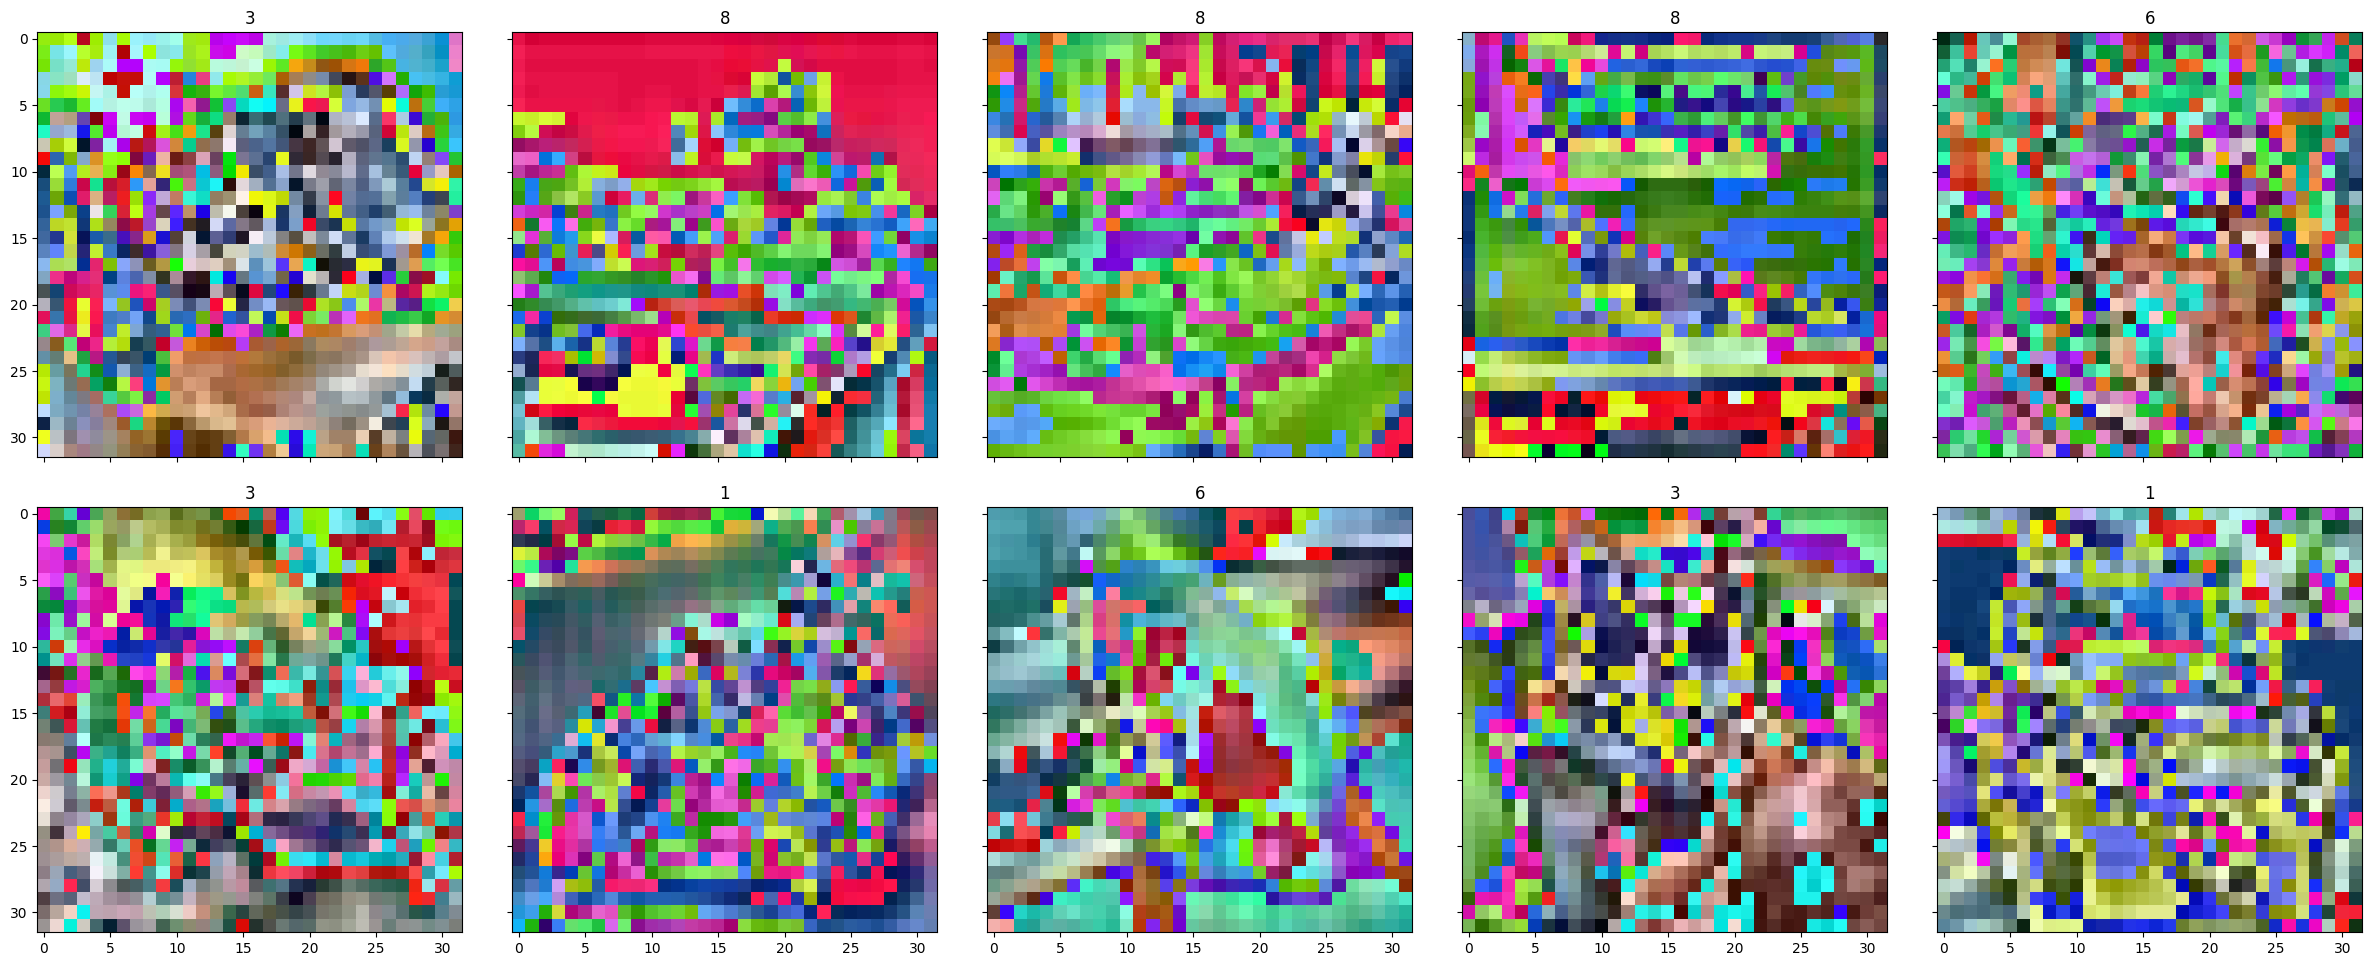

In [93]:
for input, target in _test_loader:
    input, target = input.to(device), target.to(device)
    pred=resnet(input)

# print(pred.shape)
pred_sample=pred.cpu()
pred_input=input.cpu()
print(pred_sample.shape)
print(pred_input.shape)
PredandImage_visuallization(pred_sample, pred_input)

# Summary `torch`
- `torch.tensor`: PyTorch tensors work like numpy arrays, but can remember gradients and be sent to GPUs
- `torch.nn`
    - `torch.nn.funciotnal` : Provides various useful functions (non stateful) for training neural networks, e.g. activation functions and loss functions
    - `nn.Module` : Subclass from this to create a callable that acts like a function, but can remember stat. It knows what parameters and submodules it contains and privides various functionality based on that
    - `nn.Parameters` : Wraps a tensor and tells the containing Module that it needs updating dusring backpropagation
    - `torch.nn` : Many useful layers are already implemented in this library e.g. nn.Linear, nn.Conv2d
    - `nn.Sequential` : Provides an easy way of defining purely stacked modules

- `torch.optim` : Optimizers such as SGD or Adam, which let you easily update and train the paramters inside the passed model

- `Dataset(Tensordataset)` : interface for data using only the __len__ and __getitem__ functions. Tensors can be converetd into a Dataset by using Tensor Dataset

- `DataLoader` : Takes any Dataset and provides an iterator for returning mini-bathces with various advanced functionality
 
- `GPU` : To use your GPU you need to move your model and each mini-batch to your GPU using __.to(devide)__